# Лабораторная работа №8 (Проведение исследований моделями обнаружения и распознавания объектов)

## Создание бейзлайна и оценка качества

Загрузка библиотек, если не установлено

In [ ]:
%pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.8/978.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 63.2 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [31]:
%pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 7.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
%pip install optuna

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


Импорт библиотек

In [2]:
import copy
import os
import random
import shutil
import time
import xml.etree.ElementTree as ET
from collections import Counter

import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import optuna
import plotly.express as pe
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
import torchvision
import torchvision.transforms.functional as F
from PIL import Image, ImageDraw
from torch.utils.data import DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision import datasets, models, transforms, utils
from torchvision.datasets import VOCDetection
from tqdm.notebook import tqdm
from ultralytics import YOLO

Подготовка датасета: конвертация формата датасета в поддерживаемый YOLO формат

In [3]:
VOC_CLASSES = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]


def convert_voc_to_yolo(voc_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for xml_file in os.listdir(os.path.join(voc_dir, "Annotations")):
        if not xml_file.endswith(".xml"):
            continue
        tree = ET.parse(os.path.join(voc_dir, "Annotations", xml_file))
        root = tree.getroot()

        img_width = int(root.find("size/width").text)
        img_height = int(root.find("size/height").text)

        yolo_annotation = []
        for obj in root.findall("object"):
            class_id = VOC_CLASSES.index(obj.find("name").text)
            bbox = obj.find("bndbox")
            xmin, ymin, xmax, ymax = [
                float(bbox.find(tag).text) for tag in ["xmin", "ymin", "xmax", "ymax"]
            ]
            x_center = (xmin + xmax) / 2 / img_width
            y_center = (ymin + ymax) / 2 / img_height
            width = (xmax - xmin) / img_width
            height = (ymax - ymin) / img_height
            yolo_annotation.append(
                f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
            )

        with open(
            os.path.join(output_dir, f"{root.find('filename').text.split('.')[0]}.txt"),
            "w",
        ) as f:
            f.write("\n".join(yolo_annotation))

In [11]:
voc_dir = "/home/jupyter/work/resources/data/VOCdevkit/VOC2007"
output_dir = "/home/jupyter/work/resources/data/VOCdevkit/VOC2007/yolo_labels"
convert_voc_to_yolo(voc_dir, output_dir)

In [12]:
voc_images_dir = "/home/jupyter/work/resources/data/VOCdevkit/VOC2007/JPEGImages"
voc_labels_dir = "/home/jupyter/work/resources/data/VOCdevkit/VOC2007/yolo_labels"
imagesets_dir = "/home/jupyter/work/resources/data/VOCdevkit/VOC2007/ImageSets/Main"
subset_train_dir = "/home/jupyter/work/resources/data/VOCdevkit/VOC2007/datasets/train"
subset_val_dir = "/home/jupyter/work/resources/data/VOCdevkit/VOC2007/datasets/val"

os.makedirs(os.path.join(subset_train_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(subset_train_dir, "labels"), exist_ok=True)
os.makedirs(os.path.join(subset_val_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(subset_val_dir, "labels"), exist_ok=True)


def select_random_subset(list_file, subset_size):
    with open(list_file, "r") as f:
        file_list = f.read().strip().split()
    random.shuffle(file_list)
    return file_list[:subset_size]


def copy_files_from_list(
    file_list, source_img_dir, source_lbl_dir, dest_img_dir, dest_lbl_dir
):
    for file_name in file_list:
        img_file = file_name + ".jpg"
        lbl_file = file_name + ".txt"

        shutil.copy(
            os.path.join(source_img_dir, img_file), os.path.join(dest_img_dir, img_file)
        )

        shutil.copy(
            os.path.join(source_lbl_dir, lbl_file), os.path.join(dest_lbl_dir, lbl_file)
        )


train_subset_size = 1000
val_subset_size = 100

train_files_subset = select_random_subset(
    os.path.join(imagesets_dir, "train.txt"), train_subset_size
)
val_files_subset = select_random_subset(
    os.path.join(imagesets_dir, "val.txt"), val_subset_size
)

copy_files_from_list(
    train_files_subset,
    voc_images_dir,
    voc_labels_dir,
    os.path.join(subset_train_dir, "images"),
    os.path.join(subset_train_dir, "labels"),
)

copy_files_from_list(
    val_files_subset,
    voc_images_dir,
    voc_labels_dir,
    os.path.join(subset_val_dir, "images"),
    os.path.join(subset_val_dir, "labels"),
)

In [13]:
yaml_content = """
train: /home/jupyter/work/resources/data/VOCdevkit/VOC2007/datasets/train/images
val: /home/jupyter/work/resources/data/VOCdevkit/VOC2007/datasets/val/images

nc: 20  # number of classes
names: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
        'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
        'train', 'tvmonitor']
"""

# Save the YAML content to a file
yaml_path = "/home/jupyter/work/resources/data/VOCdevkit/VOC2007/datasets/subset.yaml"
with open(yaml_path, "w") as f:
    f.write(yaml_content)

### Обучение модели

In [18]:
model_yolo = YOLO("yolo11n.pt")  # load a pretrained model (recommended for training)

model_yolo.train(data=yaml_path, epochs=5, imgsz=256, batch=20)

Ultralytics 8.3.111 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81229MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/home/jupyter/work/resources/data/VOCdevkit/VOC2007/datasets/subset.yaml, epochs=5, time=None, patience=100, batch=20, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sho

train: Scanning /home/jupyter/work/resources/data/VOCdevkit/VOC2007/datasets/train/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'


val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 72.9±18.2 MB/s, size: 78.3 KB)


val: Scanning /home/jupyter/work/resources/data/VOCdevkit/VOC2007/datasets/val/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00046875), 87 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to runs/detect/train4
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      1.09G      1.363      4.347      1.283         97        256: 100%|██████████| 50/50 [00:05<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 16.25it/s]


                   all        100        309     0.0465     0.0696     0.0506     0.0412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.09G      1.346      3.921      1.218        116        256: 100%|██████████| 50/50 [00:03<00:00, 13.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.67it/s]

                   all        100        309     0.0459      0.411      0.164      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.09G      1.402      3.472      1.243        113        256: 100%|██████████| 50/50 [00:03<00:00, 14.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.48it/s]

                   all        100        309      0.612      0.199      0.256       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.09G      1.425       3.07      1.246        105        256: 100%|██████████| 50/50 [00:03<00:00, 14.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.21it/s]

                   all        100        309      0.507      0.268      0.293      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.09G      1.394      2.841      1.239        102        256: 100%|██████████| 50/50 [00:03<00:00, 15.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.72it/s]

                   all        100        309      0.493      0.308      0.329      0.238



5 epochs completed in 0.008 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 5.4MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81229MiB)
YOLO11n summary (fused): 100 layers, 2,586,052 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


                   all        100        309      0.492      0.308       0.33      0.239
             aeroplane          4          6      0.446      0.167      0.244      0.202
               bicycle          3         16       0.18     0.0625     0.0225     0.0203
                  bird          5          5      0.205        0.6      0.515      0.441
                  boat          2          6      0.178      0.149     0.0535     0.0335
                bottle          4          7          1          0      0.157      0.152
                   bus          2          2          0          0     0.0116    0.00666
                   car          9         28      0.446      0.643      0.599       0.43
                   cat          4          4      0.429        0.5      0.426      0.355
                 chair         15         41      0.403      0.171      0.179     0.0889
                   cow          3          5      0.363        0.2      0.181      0.138
           diningtabl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f9c42d6d600>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043

### Оценка модели

In [19]:
metrics = model_yolo.val()
metrics.box.map

Ultralytics 8.3.111 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81229MiB)
YOLO11n summary (fused): 100 layers, 2,586,052 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.0 ms, read: 63.3±29.5 MB/s, size: 69.9 KB)


val: Scanning /home/jupyter/work/resources/data/VOCdevkit/VOC2007/datasets/val/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


                   all        100        309      0.494      0.286      0.312      0.225
             aeroplane          4          6       0.52      0.167      0.254      0.227
               bicycle          3         16      0.191     0.0478     0.0171     0.0154
                  bird          5          5      0.278        0.8       0.57      0.488
                  boat          2          6          0          0     0.0427     0.0269
                bottle          4          7          1          0      0.156      0.151
                   bus          2          2          0          0     0.0112    0.00642
                   car          9         28      0.489      0.571      0.582       0.42
                   cat          4          4      0.461        0.5      0.324      0.239
                 chair         15         41       0.36      0.171      0.188     0.0952
                   cow          3          5      0.195        0.2      0.108     0.0811
           diningtabl

0.2251788043762712

![F1 curve](./runs/detect/train42/F1_curve.png)

Несколько примеров прогноза

![val_batch0_pred](./runs/detect/train42/val_batch0_pred.jpg)

## Улучшение бейзлайна

### Формулирование гипотез

#### Гипотеза 1: Подбор гиперпараметров

Цель: Найти оптимальные гиперпараметры для улучшения обучения и обобщения.

### Проверка гипотез

#### Подбор гиперпараметров

In [25]:
model_yolo = YOLO("yolo11n.pt")

model_yolo.train(data=yaml_path, epochs=100, imgsz=640)

Ultralytics 8.3.111 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81229MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/home/jupyter/work/resources/data/VOCdevkit/VOC2007/datasets/subset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, s

train: Scanning /home/jupyter/work/resources/data/VOCdevkit/VOC2007/datasets/train/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'


val: Fast image access ✅ (ping: 0.5±0.0 ms, read: 66.6±19.9 MB/s, size: 78.3 KB)


val: Scanning /home/jupyter/work/resources/data/VOCdevkit/VOC2007/datasets/val/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train6
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.49G      1.016       3.89      1.217         60        640: 100%|██████████| 63/63 [00:08<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

                   all        100        309      0.039      0.353     0.0807      0.062



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.65G      1.102      3.141      1.283         72        640: 100%|██████████| 63/63 [00:05<00:00, 12.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.76it/s]


                   all        100        309      0.667      0.274      0.332      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.65G      1.166      2.539       1.34         53        640: 100%|██████████| 63/63 [00:04<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.83it/s]

                   all        100        309      0.468      0.449      0.454        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.65G       1.19      2.183      1.345         60        640: 100%|██████████| 63/63 [00:04<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.92it/s]

                   all        100        309      0.507      0.474      0.476      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.65G      1.192      2.008      1.346         39        640: 100%|██████████| 63/63 [00:05<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.15it/s]

                   all        100        309      0.605      0.468      0.492      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.65G      1.142      1.843      1.322         71        640: 100%|██████████| 63/63 [00:04<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.75it/s]

                   all        100        309      0.519      0.454      0.489       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.65G      1.142      1.746      1.308         54        640: 100%|██████████| 63/63 [00:04<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.80it/s]

                   all        100        309      0.709      0.492      0.617       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.65G      1.112      1.689      1.305         46        640: 100%|██████████| 63/63 [00:04<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.26it/s]

                   all        100        309      0.628      0.524      0.562      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.65G      1.103      1.656      1.293         36        640: 100%|██████████| 63/63 [00:04<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.31it/s]

                   all        100        309      0.604      0.484      0.545      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.65G      1.089      1.594      1.275         42        640: 100%|██████████| 63/63 [00:05<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.44it/s]

                   all        100        309      0.591       0.53      0.573      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.65G      1.071      1.531      1.267         59        640: 100%|██████████| 63/63 [00:05<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.22it/s]

                   all        100        309      0.507      0.491      0.516      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.65G      1.057      1.497      1.257         41        640: 100%|██████████| 63/63 [00:04<00:00, 12.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.64it/s]

                   all        100        309      0.682      0.483      0.564      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.65G      1.048       1.46      1.249         43        640: 100%|██████████| 63/63 [00:04<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.52it/s]

                   all        100        309      0.516      0.593      0.571      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.65G      1.054      1.466      1.257         44        640: 100%|██████████| 63/63 [00:05<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.68it/s]

                   all        100        309      0.698        0.5      0.604      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.65G      1.019      1.415       1.24         60        640: 100%|██████████| 63/63 [00:04<00:00, 12.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.16it/s]

                   all        100        309      0.592       0.48      0.577      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.65G      1.024      1.357       1.23         78        640: 100%|██████████| 63/63 [00:04<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.52it/s]

                   all        100        309      0.774      0.538      0.643      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.65G      1.001      1.354      1.227         30        640: 100%|██████████| 63/63 [00:04<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.39it/s]

                   all        100        309      0.647      0.477       0.56      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.65G      1.009      1.296      1.219         86        640: 100%|██████████| 63/63 [00:05<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.48it/s]

                   all        100        309       0.67      0.528       0.61      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.65G     0.9979      1.294      1.218         63        640: 100%|██████████| 63/63 [00:04<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.20it/s]

                   all        100        309      0.654      0.514      0.586      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.65G     0.9966      1.295      1.213         66        640: 100%|██████████| 63/63 [00:04<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.61it/s]

                   all        100        309      0.622      0.572      0.577      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.65G     0.9847      1.263      1.214         31        640: 100%|██████████| 63/63 [00:04<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.52it/s]

                   all        100        309      0.646      0.544      0.598      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.65G     0.9717      1.196      1.203         58        640: 100%|██████████| 63/63 [00:05<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.44it/s]

                   all        100        309      0.562      0.537      0.583      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.65G     0.9696      1.235      1.205         77        640: 100%|██████████| 63/63 [00:05<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.58it/s]

                   all        100        309      0.805      0.458      0.618      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.65G     0.9684      1.191      1.192         49        640: 100%|██████████| 63/63 [00:05<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.58it/s]

                   all        100        309      0.663       0.52      0.596      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.65G     0.9619       1.15      1.195         49        640: 100%|██████████| 63/63 [00:05<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.14it/s]

                   all        100        309      0.705       0.58      0.642      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.65G     0.9326       1.15      1.174         53        640: 100%|██████████| 63/63 [00:04<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.64it/s]

                   all        100        309        0.7      0.528      0.605      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.65G      0.945      1.131      1.176         58        640: 100%|██████████| 63/63 [00:05<00:00, 12.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.37it/s]

                   all        100        309      0.782      0.531      0.644      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.65G     0.9196      1.106      1.173         55        640: 100%|██████████| 63/63 [00:04<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.66it/s]

                   all        100        309      0.617      0.589      0.591      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.65G     0.9354      1.114       1.18         57        640: 100%|██████████| 63/63 [00:04<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.52it/s]

                   all        100        309      0.673      0.468      0.591      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.65G     0.9216      1.072      1.161         51        640: 100%|██████████| 63/63 [00:05<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.51it/s]

                   all        100        309      0.577      0.542      0.587      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.65G     0.9259      1.074      1.158         52        640: 100%|██████████| 63/63 [00:04<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.52it/s]

                   all        100        309      0.595      0.623      0.645       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.65G     0.9164      1.061      1.166         40        640: 100%|██████████| 63/63 [00:04<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.19it/s]

                   all        100        309      0.663      0.549      0.645       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.65G     0.9061      1.028      1.144         53        640: 100%|██████████| 63/63 [00:04<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.54it/s]

                   all        100        309      0.744      0.495      0.616      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.65G     0.9052      1.025      1.157         57        640: 100%|██████████| 63/63 [00:05<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.31it/s]

                   all        100        309      0.689      0.531      0.648      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.65G      0.887      1.006      1.141         89        640: 100%|██████████| 63/63 [00:04<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.53it/s]


                   all        100        309      0.709      0.579      0.637      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.65G     0.9077     0.9978      1.153         41        640: 100%|██████████| 63/63 [00:04<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.47it/s]

                   all        100        309      0.634      0.607      0.626      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.65G     0.8832     0.9803      1.143         51        640: 100%|██████████| 63/63 [00:04<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.55it/s]

                   all        100        309       0.68      0.596      0.647      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.65G     0.8717     0.9711      1.131         47        640: 100%|██████████| 63/63 [00:04<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.32it/s]

                   all        100        309      0.676      0.575      0.639      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.65G     0.8727     0.9713      1.131         40        640: 100%|██████████| 63/63 [00:04<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.78it/s]

                   all        100        309      0.744      0.537      0.628      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.65G     0.8664     0.9422      1.129         40        640: 100%|██████████| 63/63 [00:04<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.49it/s]

                   all        100        309      0.628      0.528       0.62      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.65G      0.851     0.9375      1.126         65        640: 100%|██████████| 63/63 [00:05<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.67it/s]

                   all        100        309      0.696      0.563      0.625      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.65G     0.8633     0.9303      1.117         45        640: 100%|██████████| 63/63 [00:04<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.84it/s]

                   all        100        309      0.666      0.581       0.65      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.65G     0.8564     0.9183      1.119         63        640: 100%|██████████| 63/63 [00:04<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.21it/s]

                   all        100        309      0.583       0.62      0.637      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.65G      0.862      0.906      1.113         79        640: 100%|██████████| 63/63 [00:04<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.69it/s]

                   all        100        309      0.704      0.571      0.676      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.65G     0.8476     0.8906      1.114         54        640: 100%|██████████| 63/63 [00:04<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.86it/s]

                   all        100        309      0.698      0.577      0.642      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.65G     0.8245     0.8731      1.098         50        640: 100%|██████████| 63/63 [00:04<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.86it/s]

                   all        100        309      0.745      0.588      0.681      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.65G     0.8397     0.8817      1.108         85        640: 100%|██████████| 63/63 [00:05<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.53it/s]

                   all        100        309      0.659      0.558      0.653      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.65G     0.8355     0.8615        1.1         27        640: 100%|██████████| 63/63 [00:04<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.54it/s]

                   all        100        309      0.618      0.591      0.631      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.65G     0.8166     0.8557      1.096         78        640: 100%|██████████| 63/63 [00:04<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.79it/s]

                   all        100        309      0.591      0.656      0.647      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.65G     0.8031     0.8442      1.092         34        640: 100%|██████████| 63/63 [00:04<00:00, 13.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.88it/s]

                   all        100        309      0.635      0.589      0.632      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.65G     0.8085      0.832      1.092         46        640: 100%|██████████| 63/63 [00:04<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.87it/s]

                   all        100        309      0.684      0.528      0.628      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.65G     0.8026     0.8355      1.084         36        640: 100%|██████████| 63/63 [00:04<00:00, 13.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.72it/s]


                   all        100        309      0.795        0.5      0.641      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.65G     0.7875     0.8143      1.089         54        640: 100%|██████████| 63/63 [00:04<00:00, 13.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.02it/s]

                   all        100        309      0.755      0.576      0.663      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.65G     0.7947     0.8254      1.081         38        640: 100%|██████████| 63/63 [00:04<00:00, 13.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.78it/s]

                   all        100        309      0.635      0.619      0.656      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.65G     0.8041     0.8267      1.089         42        640: 100%|██████████| 63/63 [00:04<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.90it/s]

                   all        100        309      0.773      0.542      0.656      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.65G     0.7622      0.785      1.067         55        640: 100%|██████████| 63/63 [00:04<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.69it/s]

                   all        100        309      0.777      0.574      0.667      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.65G     0.7894     0.7911      1.082         38        640: 100%|██████████| 63/63 [00:05<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.38it/s]

                   all        100        309      0.704      0.565      0.632      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.65G     0.7777     0.7768      1.073         49        640: 100%|██████████| 63/63 [00:05<00:00, 11.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.22it/s]

                   all        100        309      0.685      0.598       0.66      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.65G     0.7853     0.7848      1.075         45        640: 100%|██████████| 63/63 [00:05<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.76it/s]

                   all        100        309      0.756      0.559      0.662      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.65G      0.759      0.758       1.06         44        640: 100%|██████████| 63/63 [00:04<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.66it/s]

                   all        100        309      0.659       0.58      0.634      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.65G     0.7578     0.7715      1.068         64        640: 100%|██████████| 63/63 [00:04<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.69it/s]

                   all        100        309      0.646      0.621       0.64      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.65G     0.7622     0.7666      1.063         58        640: 100%|██████████| 63/63 [00:04<00:00, 12.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.72it/s]

                   all        100        309      0.587      0.619      0.628      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.65G     0.7523     0.7442      1.055         53        640: 100%|██████████| 63/63 [00:04<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.81it/s]

                   all        100        309      0.672      0.591      0.633      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.65G     0.7528     0.7513      1.068         47        640: 100%|██████████| 63/63 [00:04<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.46it/s]

                   all        100        309       0.64      0.596      0.634      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.65G     0.7506     0.7426      1.057         59        640: 100%|██████████| 63/63 [00:04<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.97it/s]

                   all        100        309      0.736       0.57      0.645      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.65G     0.7213     0.7273      1.052         56        640: 100%|██████████| 63/63 [00:05<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.63it/s]


                   all        100        309       0.76      0.525      0.634      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.65G     0.7466     0.7227      1.054         32        640: 100%|██████████| 63/63 [00:05<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.48it/s]

                   all        100        309      0.746      0.523      0.638      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.65G     0.7324     0.7245      1.047         47        640: 100%|██████████| 63/63 [00:04<00:00, 12.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.78it/s]

                   all        100        309      0.673      0.567      0.623      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.65G     0.7412     0.7092      1.051         59        640: 100%|██████████| 63/63 [00:04<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.78it/s]

                   all        100        309        0.7      0.554      0.606      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.65G     0.7189     0.7074      1.041         64        640: 100%|██████████| 63/63 [00:04<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.15it/s]

                   all        100        309      0.669      0.598      0.648      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.65G     0.7337     0.7098      1.047         45        640: 100%|██████████| 63/63 [00:04<00:00, 13.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.09it/s]

                   all        100        309      0.692      0.559      0.631      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.65G     0.7125     0.6945      1.042         62        640: 100%|██████████| 63/63 [00:04<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.06it/s]

                   all        100        309      0.678      0.563      0.639       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.65G     0.7345     0.6975      1.047         46        640: 100%|██████████| 63/63 [00:04<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.71it/s]

                   all        100        309      0.652      0.637      0.656       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.65G     0.7138     0.6841       1.04         58        640: 100%|██████████| 63/63 [00:05<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.83it/s]

                   all        100        309      0.642      0.642      0.666      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.65G     0.7237     0.6864      1.037        111        640: 100%|██████████| 63/63 [00:04<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.01it/s]

                   all        100        309      0.632      0.616      0.663      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.65G     0.7036     0.6828      1.035         31        640: 100%|██████████| 63/63 [00:04<00:00, 13.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.93it/s]


                   all        100        309      0.742      0.568      0.666      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.65G     0.6827     0.6728      1.027         53        640: 100%|██████████| 63/63 [00:04<00:00, 13.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.98it/s]

                   all        100        309      0.663      0.598      0.645      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.65G     0.7112     0.6834      1.034         34        640: 100%|██████████| 63/63 [00:05<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.18it/s]

                   all        100        309      0.624      0.622      0.658      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.65G     0.7108     0.6912      1.039         57        640: 100%|██████████| 63/63 [00:04<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.08it/s]

                   all        100        309      0.701      0.589       0.66      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.65G     0.6865      0.666      1.036         40        640: 100%|██████████| 63/63 [00:04<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.74it/s]

                   all        100        309      0.703      0.582      0.655      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.65G     0.6983     0.6681      1.026         56        640: 100%|██████████| 63/63 [00:04<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.15it/s]


                   all        100        309      0.735      0.576      0.647       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.65G      0.675     0.6513      1.022         82        640: 100%|██████████| 63/63 [00:05<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.26it/s]

                   all        100        309        0.7      0.585       0.66      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.65G     0.6965     0.6614      1.031         53        640: 100%|██████████| 63/63 [00:04<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.78it/s]

                   all        100        309      0.631      0.593      0.658      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.65G     0.6977     0.6562      1.029         46        640: 100%|██████████| 63/63 [00:05<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.44it/s]

                   all        100        309      0.639      0.592      0.641      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.65G     0.6782     0.6386      1.017         90        640: 100%|██████████| 63/63 [00:05<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.65it/s]

                   all        100        309      0.751      0.539      0.644      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.65G      0.679     0.6513       1.02         69        640: 100%|██████████| 63/63 [00:05<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.59it/s]

                   all        100        309      0.737      0.571      0.664      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.65G     0.6872      0.637      1.024         33        640: 100%|██████████| 63/63 [00:05<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.55it/s]

                   all        100        309      0.702      0.624      0.663      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.65G     0.6729      0.641      1.022         45        640: 100%|██████████| 63/63 [00:05<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.85it/s]

                   all        100        309      0.817       0.58      0.685      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.65G     0.6602      0.621       1.01         41        640: 100%|██████████| 63/63 [00:04<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.83it/s]


                   all        100        309      0.759      0.607      0.682      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.65G      0.662     0.6266      1.017         51        640: 100%|██████████| 63/63 [00:04<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.74it/s]

                   all        100        309      0.715      0.607      0.672      0.512


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.65G     0.6317     0.6086     0.9746         25        640: 100%|██████████| 63/63 [00:06<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.79it/s]

                   all        100        309      0.722      0.583      0.632       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.65G     0.6239     0.5599     0.9646         32        640: 100%|██████████| 63/63 [00:04<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.00it/s]

                   all        100        309      0.696      0.582      0.632      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.65G     0.6039     0.5389     0.9539         29        640: 100%|██████████| 63/63 [00:04<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.69it/s]

                   all        100        309      0.675      0.596      0.632      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.65G     0.5856     0.5219      0.939         13        640: 100%|██████████| 63/63 [00:04<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.74it/s]

                   all        100        309      0.726      0.568       0.63      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.65G     0.5828     0.5201     0.9406         25        640: 100%|██████████| 63/63 [00:04<00:00, 13.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.72it/s]

                   all        100        309      0.685      0.559      0.624      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.65G     0.5719      0.503     0.9436         19        640: 100%|██████████| 63/63 [00:04<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.65it/s]

                   all        100        309      0.585      0.652      0.633      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.65G     0.5707     0.5047     0.9437         16        640: 100%|██████████| 63/63 [00:05<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.12it/s]

                   all        100        309      0.681      0.596      0.632      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.65G     0.5771     0.4997     0.9401         21        640: 100%|██████████| 63/63 [00:04<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.99it/s]

                   all        100        309      0.636      0.605      0.626      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.65G     0.5836     0.5064      0.937         31        640: 100%|██████████| 63/63 [00:04<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.02it/s]

                   all        100        309      0.625      0.617      0.632      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.65G     0.5606     0.4984     0.9359         32        640: 100%|██████████| 63/63 [00:04<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.91it/s]

                   all        100        309      0.634      0.627      0.635       0.48



100 epochs completed in 0.165 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 5.5MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81229MiB)
YOLO11n summary (fused): 100 layers, 2,586,052 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


                   all        100        309      0.731      0.595      0.681      0.518
             aeroplane          4          6      0.945      0.833      0.837      0.572
               bicycle          3         16      0.561     0.0625      0.103      0.066
                  bird          5          5      0.777      0.707      0.808      0.641
                  boat          2          6      0.878        0.5      0.549       0.44
                bottle          4          7      0.878      0.571      0.713       0.48
                   bus          2          2          1      0.737      0.995      0.895
                   car          9         28       0.78      0.893      0.874      0.649
                   cat          4          4      0.513       0.75      0.808      0.786
                 chair         15         41      0.588      0.341      0.421      0.232
                   cow          3          5      0.497        0.8      0.632      0.513
           diningtabl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f9c503690c0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043

In [26]:
metrics = model_yolo.val()
metrics.box.map

Ultralytics 8.3.111 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81229MiB)
YOLO11n summary (fused): 100 layers, 2,586,052 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 491.7±156.1 MB/s, size: 69.9 KB)


val: Scanning /home/jupyter/work/resources/data/VOCdevkit/VOC2007/datasets/val/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.50it/s]


                   all        100        309      0.743      0.599      0.683      0.529
             aeroplane          4          6      0.949      0.833      0.837      0.555
               bicycle          3         16      0.566     0.0625     0.0997     0.0649
                  bird          5          5      0.632      0.695      0.828      0.738
                  boat          2          6      0.881        0.5      0.548       0.44
                bottle          4          7      0.885      0.571      0.713       0.48
                   bus          2          2          1      0.733      0.995      0.995
                   car          9         28      0.814      0.893       0.89      0.663
                   cat          4          4      0.522       0.75      0.808      0.786
                 chair         15         41      0.601      0.341       0.42      0.231
                   cow          3          5       0.47        0.8      0.603      0.488
           diningtabl

0.5292816622022157

### Формирование улучшенного бейзлайна

In [27]:
EPOCHS = 100
IMGSZ = 640

model_yolo = YOLO("yolo11n.pt")

### Обучение модели

In [28]:
model_yolo.train(data=yaml_path, epochs=EPOCHS, imgsz=IMGSZ)

Ultralytics 8.3.111 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81229MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/home/jupyter/work/resources/data/VOCdevkit/VOC2007/datasets/subset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, s

train: Scanning /home/jupyter/work/resources/data/VOCdevkit/VOC2007/datasets/train/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 452.7±63.2 MB/s, size: 78.3 KB)


val: Scanning /home/jupyter/work/resources/data/VOCdevkit/VOC2007/datasets/val/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train7
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.48G      1.016       3.89      1.217         60        640: 100%|██████████| 63/63 [00:07<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.76it/s]

                   all        100        309      0.039      0.353     0.0807      0.062



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.64G      1.102      3.141      1.283         72        640: 100%|██████████| 63/63 [00:05<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.38it/s]


                   all        100        309      0.667      0.274      0.332      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.64G      1.166      2.539       1.34         53        640: 100%|██████████| 63/63 [00:05<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.90it/s]


                   all        100        309      0.468      0.449      0.454        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.64G       1.19      2.183      1.345         60        640: 100%|██████████| 63/63 [00:04<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.69it/s]

                   all        100        309      0.507      0.474      0.476      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.64G      1.192      2.008      1.346         39        640: 100%|██████████| 63/63 [00:04<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.17it/s]

                   all        100        309      0.605      0.468      0.492      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.64G      1.142      1.843      1.322         71        640: 100%|██████████| 63/63 [00:05<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.24it/s]

                   all        100        309      0.519      0.454      0.489       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.64G      1.142      1.746      1.308         54        640: 100%|██████████| 63/63 [00:04<00:00, 12.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.52it/s]

                   all        100        309      0.709      0.492      0.617       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.64G      1.112      1.689      1.305         46        640: 100%|██████████| 63/63 [00:04<00:00, 13.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.13it/s]

                   all        100        309      0.628      0.524      0.562      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.64G      1.103      1.656      1.293         36        640: 100%|██████████| 63/63 [00:04<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.18it/s]

                   all        100        309      0.604      0.484      0.545      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.64G      1.089      1.594      1.275         42        640: 100%|██████████| 63/63 [00:05<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.52it/s]

                   all        100        309      0.591       0.53      0.573      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.64G      1.071      1.531      1.267         59        640: 100%|██████████| 63/63 [00:04<00:00, 13.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.41it/s]

                   all        100        309      0.507      0.491      0.516      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.64G      1.057      1.497      1.257         41        640: 100%|██████████| 63/63 [00:05<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.19it/s]

                   all        100        309      0.682      0.483      0.564      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.64G      1.048       1.46      1.249         43        640: 100%|██████████| 63/63 [00:05<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.65it/s]

                   all        100        309      0.516      0.593      0.571      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.64G      1.054      1.466      1.257         44        640: 100%|██████████| 63/63 [00:05<00:00, 12.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.70it/s]

                   all        100        309      0.698        0.5      0.604      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.64G      1.019      1.415       1.24         60        640: 100%|██████████| 63/63 [00:05<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.41it/s]

                   all        100        309      0.592       0.48      0.577      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.64G      1.024      1.357       1.23         78        640: 100%|██████████| 63/63 [00:04<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.81it/s]

                   all        100        309      0.774      0.538      0.643      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.64G      1.001      1.354      1.227         30        640: 100%|██████████| 63/63 [00:04<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.60it/s]

                   all        100        309      0.647      0.477       0.56      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.64G      1.009      1.296      1.219         86        640: 100%|██████████| 63/63 [00:05<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.76it/s]

                   all        100        309       0.67      0.528       0.61      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.64G     0.9979      1.294      1.218         63        640: 100%|██████████| 63/63 [00:04<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.74it/s]


                   all        100        309      0.654      0.514      0.586      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.64G     0.9966      1.295      1.213         66        640: 100%|██████████| 63/63 [00:04<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.37it/s]

                   all        100        309      0.622      0.572      0.577      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.64G     0.9847      1.263      1.214         31        640: 100%|██████████| 63/63 [00:05<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.28it/s]

                   all        100        309      0.646      0.544      0.598      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.64G     0.9717      1.196      1.203         58        640: 100%|██████████| 63/63 [00:05<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.87it/s]

                   all        100        309      0.562      0.537      0.583      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.64G     0.9696      1.235      1.205         77        640: 100%|██████████| 63/63 [00:05<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.17it/s]

                   all        100        309      0.805      0.458      0.618      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.64G     0.9684      1.191      1.192         49        640: 100%|██████████| 63/63 [00:04<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.79it/s]

                   all        100        309      0.663       0.52      0.596      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.64G     0.9619       1.15      1.195         49        640: 100%|██████████| 63/63 [00:04<00:00, 13.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.76it/s]

                   all        100        309      0.705       0.58      0.642      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.64G     0.9326       1.15      1.174         53        640: 100%|██████████| 63/63 [00:04<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.48it/s]

                   all        100        309        0.7      0.528      0.605      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.64G      0.945      1.131      1.176         58        640: 100%|██████████| 63/63 [00:04<00:00, 12.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.78it/s]

                   all        100        309      0.782      0.531      0.644      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.64G     0.9196      1.106      1.173         55        640: 100%|██████████| 63/63 [00:04<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.32it/s]

                   all        100        309      0.617      0.589      0.591      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.64G     0.9354      1.114       1.18         57        640: 100%|██████████| 63/63 [00:05<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.01it/s]

                   all        100        309      0.673      0.468      0.591      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.64G     0.9216      1.072      1.161         51        640: 100%|██████████| 63/63 [00:05<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.69it/s]

                   all        100        309      0.577      0.542      0.587      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.64G     0.9259      1.074      1.158         52        640: 100%|██████████| 63/63 [00:05<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.74it/s]

                   all        100        309      0.595      0.623      0.645       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.64G     0.9164      1.061      1.166         40        640: 100%|██████████| 63/63 [00:05<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.40it/s]

                   all        100        309      0.663      0.549      0.645       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.64G     0.9061      1.028      1.144         53        640: 100%|██████████| 63/63 [00:05<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.55it/s]

                   all        100        309      0.744      0.495      0.616      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.64G     0.9052      1.025      1.157         57        640: 100%|██████████| 63/63 [00:05<00:00, 12.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.59it/s]

                   all        100        309      0.689      0.531      0.648      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.64G      0.887      1.006      1.141         89        640: 100%|██████████| 63/63 [00:05<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.64it/s]

                   all        100        309      0.709      0.579      0.637      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.64G     0.9077     0.9978      1.153         41        640: 100%|██████████| 63/63 [00:04<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.91it/s]

                   all        100        309      0.634      0.607      0.626      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.64G     0.8832     0.9803      1.143         51        640: 100%|██████████| 63/63 [00:05<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.09it/s]

                   all        100        309       0.68      0.596      0.647      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.64G     0.8717     0.9711      1.131         47        640: 100%|██████████| 63/63 [00:05<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.87it/s]


                   all        100        309      0.676      0.575      0.639      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.64G     0.8727     0.9713      1.131         40        640: 100%|██████████| 63/63 [00:04<00:00, 12.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.57it/s]

                   all        100        309      0.744      0.537      0.628      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.64G     0.8664     0.9422      1.129         40        640: 100%|██████████| 63/63 [00:05<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.46it/s]

                   all        100        309      0.628      0.528       0.62      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.64G      0.851     0.9375      1.126         65        640: 100%|██████████| 63/63 [00:05<00:00, 12.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.91it/s]

                   all        100        309      0.696      0.563      0.625      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.64G     0.8633     0.9303      1.117         45        640: 100%|██████████| 63/63 [00:05<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.81it/s]

                   all        100        309      0.666      0.581       0.65      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.64G     0.8564     0.9183      1.119         63        640: 100%|██████████| 63/63 [00:05<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.64it/s]

                   all        100        309      0.583       0.62      0.637      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.64G      0.862      0.906      1.113         79        640: 100%|██████████| 63/63 [00:05<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.70it/s]

                   all        100        309      0.704      0.571      0.676      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.64G     0.8476     0.8906      1.114         54        640: 100%|██████████| 63/63 [00:05<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.07it/s]


                   all        100        309      0.698      0.577      0.642      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.64G     0.8245     0.8731      1.098         50        640: 100%|██████████| 63/63 [00:05<00:00, 12.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.33it/s]

                   all        100        309      0.745      0.588      0.681      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.64G     0.8397     0.8817      1.108         85        640: 100%|██████████| 63/63 [00:05<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.02it/s]

                   all        100        309      0.659      0.558      0.653      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.64G     0.8355     0.8615        1.1         27        640: 100%|██████████| 63/63 [00:05<00:00, 12.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.17it/s]

                   all        100        309      0.618      0.591      0.631      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.64G     0.8166     0.8557      1.096         78        640: 100%|██████████| 63/63 [00:05<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.77it/s]

                   all        100        309      0.591      0.656      0.647      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.64G     0.8031     0.8442      1.092         34        640: 100%|██████████| 63/63 [00:04<00:00, 12.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.93it/s]


                   all        100        309      0.635      0.589      0.632      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.64G     0.8085      0.832      1.092         46        640: 100%|██████████| 63/63 [00:04<00:00, 12.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.45it/s]

                   all        100        309      0.684      0.528      0.628      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.64G     0.8026     0.8355      1.084         36        640: 100%|██████████| 63/63 [00:04<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.48it/s]

                   all        100        309      0.795        0.5      0.641      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.64G     0.7875     0.8143      1.089         54        640: 100%|██████████| 63/63 [00:05<00:00, 12.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.46it/s]

                   all        100        309      0.755      0.576      0.663      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.64G     0.7947     0.8254      1.081         38        640: 100%|██████████| 63/63 [00:04<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.89it/s]

                   all        100        309      0.635      0.619      0.656      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.64G     0.8041     0.8267      1.089         42        640: 100%|██████████| 63/63 [00:04<00:00, 13.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.15it/s]


                   all        100        309      0.773      0.542      0.656      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.64G     0.7622      0.785      1.067         55        640: 100%|██████████| 63/63 [00:04<00:00, 13.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.56it/s]

                   all        100        309      0.777      0.574      0.667      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.64G     0.7894     0.7911      1.082         38        640: 100%|██████████| 63/63 [00:04<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.76it/s]

                   all        100        309      0.704      0.565      0.632      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.64G     0.7777     0.7768      1.073         49        640: 100%|██████████| 63/63 [00:04<00:00, 13.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.10it/s]


                   all        100        309      0.685      0.598       0.66      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.64G     0.7853     0.7848      1.075         45        640: 100%|██████████| 63/63 [00:04<00:00, 13.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.97it/s]

                   all        100        309      0.756      0.559      0.662      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.64G      0.759      0.758       1.06         44        640: 100%|██████████| 63/63 [00:04<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.57it/s]

                   all        100        309      0.659       0.58      0.634      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.64G     0.7578     0.7715      1.068         64        640: 100%|██████████| 63/63 [00:05<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.99it/s]

                   all        100        309      0.646      0.621       0.64      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.64G     0.7622     0.7666      1.063         58        640: 100%|██████████| 63/63 [00:05<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.79it/s]

                   all        100        309      0.587      0.619      0.628      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.64G     0.7523     0.7442      1.055         53        640: 100%|██████████| 63/63 [00:04<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.92it/s]

                   all        100        309      0.672      0.591      0.633      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.64G     0.7528     0.7513      1.068         47        640: 100%|██████████| 63/63 [00:04<00:00, 12.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.02it/s]

                   all        100        309       0.64      0.596      0.634      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.64G     0.7506     0.7426      1.057         59        640: 100%|██████████| 63/63 [00:04<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.63it/s]

                   all        100        309      0.736       0.57      0.645      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.64G     0.7213     0.7273      1.052         56        640: 100%|██████████| 63/63 [00:04<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.76it/s]

                   all        100        309       0.76      0.525      0.634      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.64G     0.7466     0.7227      1.054         32        640: 100%|██████████| 63/63 [00:05<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.21it/s]

                   all        100        309      0.746      0.523      0.638      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.64G     0.7324     0.7245      1.047         47        640: 100%|██████████| 63/63 [00:04<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.81it/s]

                   all        100        309      0.673      0.567      0.623      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.64G     0.7412     0.7092      1.051         59        640: 100%|██████████| 63/63 [00:04<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.54it/s]

                   all        100        309        0.7      0.554      0.606      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.64G     0.7189     0.7074      1.041         64        640: 100%|██████████| 63/63 [00:04<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.13it/s]

                   all        100        309      0.669      0.598      0.648      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.64G     0.7337     0.7098      1.047         45        640: 100%|██████████| 63/63 [00:04<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.07it/s]

                   all        100        309      0.692      0.559      0.631      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.64G     0.7125     0.6945      1.042         62        640: 100%|██████████| 63/63 [00:05<00:00, 12.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.86it/s]


                   all        100        309      0.678      0.563      0.639       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.64G     0.7345     0.6975      1.047         46        640: 100%|██████████| 63/63 [00:05<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.00it/s]

                   all        100        309      0.652      0.637      0.656       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.64G     0.7138     0.6841       1.04         58        640: 100%|██████████| 63/63 [00:05<00:00, 12.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.24it/s]


                   all        100        309      0.642      0.642      0.666      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.64G     0.7237     0.6864      1.037        111        640: 100%|██████████| 63/63 [00:05<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.80it/s]

                   all        100        309      0.632      0.616      0.663      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.64G     0.7036     0.6828      1.035         31        640: 100%|██████████| 63/63 [00:04<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.82it/s]

                   all        100        309      0.742      0.568      0.666      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.64G     0.6827     0.6728      1.027         53        640: 100%|██████████| 63/63 [00:04<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.46it/s]

                   all        100        309      0.663      0.598      0.645      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.64G     0.7112     0.6834      1.034         34        640: 100%|██████████| 63/63 [00:04<00:00, 13.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.53it/s]

                   all        100        309      0.624      0.622      0.658      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.64G     0.7108     0.6912      1.039         57        640: 100%|██████████| 63/63 [00:04<00:00, 12.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.91it/s]

                   all        100        309      0.701      0.589       0.66      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.64G     0.6865      0.666      1.036         40        640: 100%|██████████| 63/63 [00:04<00:00, 13.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.95it/s]

                   all        100        309      0.703      0.582      0.655      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.64G     0.6983     0.6681      1.026         56        640: 100%|██████████| 63/63 [00:04<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.45it/s]

                   all        100        309      0.735      0.576      0.647       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.64G      0.675     0.6513      1.022         82        640: 100%|██████████| 63/63 [00:04<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.37it/s]

                   all        100        309        0.7      0.585       0.66      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.64G     0.6965     0.6614      1.031         53        640: 100%|██████████| 63/63 [00:04<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.02it/s]

                   all        100        309      0.631      0.593      0.658      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.64G     0.6977     0.6562      1.029         46        640: 100%|██████████| 63/63 [00:04<00:00, 13.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.57it/s]

                   all        100        309      0.639      0.592      0.641      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.64G     0.6782     0.6386      1.017         90        640: 100%|██████████| 63/63 [00:04<00:00, 12.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.36it/s]

                   all        100        309      0.751      0.539      0.644      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.64G      0.679     0.6513       1.02         69        640: 100%|██████████| 63/63 [00:04<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.78it/s]


                   all        100        309      0.737      0.571      0.664      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.64G     0.6872      0.637      1.024         33        640: 100%|██████████| 63/63 [00:05<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.55it/s]

                   all        100        309      0.702      0.624      0.663      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.64G     0.6729      0.641      1.022         45        640: 100%|██████████| 63/63 [00:05<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.37it/s]

                   all        100        309      0.817       0.58      0.685      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.64G     0.6602      0.621       1.01         41        640: 100%|██████████| 63/63 [00:05<00:00, 12.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.70it/s]


                   all        100        309      0.759      0.607      0.682      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.64G      0.662     0.6266      1.017         51        640: 100%|██████████| 63/63 [00:04<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.71it/s]

                   all        100        309      0.715      0.607      0.672      0.512


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.64G     0.6317     0.6086     0.9746         25        640: 100%|██████████| 63/63 [00:06<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.42it/s]

                   all        100        309      0.722      0.583      0.632       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.64G     0.6239     0.5599     0.9646         32        640: 100%|██████████| 63/63 [00:05<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.83it/s]


                   all        100        309      0.696      0.582      0.632      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.64G     0.6039     0.5389     0.9539         29        640: 100%|██████████| 63/63 [00:05<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.00it/s]

                   all        100        309      0.675      0.596      0.632      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.64G     0.5856     0.5219      0.939         13        640: 100%|██████████| 63/63 [00:05<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 13.19it/s]

                   all        100        309      0.726      0.568       0.63      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.64G     0.5828     0.5201     0.9406         25        640: 100%|██████████| 63/63 [00:05<00:00, 12.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.31it/s]


                   all        100        309      0.685      0.559      0.624      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.64G     0.5719      0.503     0.9436         19        640: 100%|██████████| 63/63 [00:05<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.90it/s]

                   all        100        309      0.585      0.652      0.633      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.64G     0.5707     0.5047     0.9437         16        640: 100%|██████████| 63/63 [00:05<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.35it/s]

                   all        100        309      0.681      0.596      0.632      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.64G     0.5771     0.4997     0.9401         21        640: 100%|██████████| 63/63 [00:05<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.70it/s]

                   all        100        309      0.636      0.605      0.626      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.64G     0.5836     0.5064      0.937         31        640: 100%|██████████| 63/63 [00:05<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.38it/s]

                   all        100        309      0.625      0.617      0.632      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.64G     0.5606     0.4984     0.9359         32        640: 100%|██████████| 63/63 [00:04<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 12.82it/s]

                   all        100        309      0.634      0.627      0.635       0.48



100 epochs completed in 0.166 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 5.5MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81229MiB)
YOLO11n summary (fused): 100 layers, 2,586,052 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


                   all        100        309      0.731      0.595      0.681      0.518
             aeroplane          4          6      0.945      0.833      0.837      0.572
               bicycle          3         16      0.561     0.0625      0.103      0.066
                  bird          5          5      0.777      0.707      0.808      0.641
                  boat          2          6      0.878        0.5      0.549       0.44
                bottle          4          7      0.878      0.571      0.713       0.48
                   bus          2          2          1      0.737      0.995      0.895
                   car          9         28       0.78      0.893      0.874      0.649
                   cat          4          4      0.513       0.75      0.808      0.786
                 chair         15         41      0.588      0.341      0.421      0.232
                   cow          3          5      0.497        0.8      0.632      0.513
           diningtabl

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f9c50238af0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043

### Оценка модели

In [29]:
metrics = model_yolo.val()
metrics.box.map

Ultralytics 8.3.111 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-80GB, 81229MiB)
YOLO11n summary (fused): 100 layers, 2,586,052 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 650.9±366.8 MB/s, size: 69.9 KB)


val: Scanning /home/jupyter/work/resources/data/VOCdevkit/VOC2007/datasets/val/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


                   all        100        309      0.743      0.599      0.683      0.529
             aeroplane          4          6      0.949      0.833      0.837      0.555
               bicycle          3         16      0.566     0.0625     0.0997     0.0649
                  bird          5          5      0.632      0.695      0.828      0.738
                  boat          2          6      0.881        0.5      0.548       0.44
                bottle          4          7      0.885      0.571      0.713       0.48
                   bus          2          2          1      0.733      0.995      0.995
                   car          9         28      0.814      0.893       0.89      0.663
                   cat          4          4      0.522       0.75      0.808      0.786
                 chair         15         41      0.601      0.341       0.42      0.231
                   cow          3          5       0.47        0.8      0.603      0.488
           diningtabl

0.5292816622022157

![F1 curve](./runs/detect/train72/F1_curve.png)

![val_batch0_pred](./runs/detect/train72/val_batch0_pred.jpg)

### Сравнение результатов

|              | YOLO (base)  | YOLO (upgrade) |
|--------------|:------------:|:--------------:|
| F1 Score     | 0.3000       | 0.6300         |
| mAP (50-95)  | 0.2251       | 0.5292         |

### Выводы

Модели с улучшенным бейзлайном превосходит по всем метрикам благодаря оптимизированным гиперпараметрам: количеством эпох, размером изображений.

## Имплементация алгоритма машинного обучения 

### Имплементация модели YOLO

Вспомогательные функции

In [4]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [5]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [6]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [7]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [8]:
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            # if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

In [9]:
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

In [10]:
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

In [11]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [12]:
def targ_tran(target):
    size = target["annotation"]["size"]
    x_src2trg = int(size["width"]) / 448
    y_src2trg = int(size["height"]) / 448
    objcts = target["annotation"]["object"]
    target = {"boxes": [], "labels": [], "difficults": []}
    for objct in objcts:
        class_list = np.zeros(len(classes), dtype=np.int64).tolist()
        class_list[classes.index(objct["name"])] = 1
        target["boxes"].append(
            [
                int(objct["bndbox"]["xmin"]) / x_src2trg,
                int(objct["bndbox"]["ymin"]) / y_src2trg,
                int(objct["bndbox"]["xmax"]) / x_src2trg,
                int(objct["bndbox"]["ymax"]) / y_src2trg,
            ]
        )
        target["labels"].append(classes.index(objct["name"]))
        target["difficults"].append(int(objct["difficult"]))
    target["labels"] = torch.LongTensor(target["labels"])
    target["boxes"] = torch.FloatTensor(target["boxes"])
    target["difficults"] = torch.LongTensor(target["difficults"])
    return target


def imshow(img_pt, trues, preds=None):
    img = F.to_pil_image(img_pt)
    size = img.size
    fig = pe.imshow(img)
    for box, label_list in zip(trues["boxes"], trues["labels"]):
        label_text = classes[label_list]
        fig.add_shape(
            type="rect",
            x0=box[0],
            x1=box[2],
            y0=box[1],
            y1=box[3],
            xref="x",
            yref="y",
            line=dict(color="red", width=2),
        )
        fig.add_annotation(
            x=box[0],
            y=box[1],
            text=label_text,
            xref="x",
            yref="y",
            showarrow=False,
            font_size=15,
            font_color="green",
            bgcolor="white",
        )

    if preds != None:
        for box, label_list, score in zip(
            preds["boxes"].cpu().tolist(),
            preds["labels"].cpu().tolist(),
            preds["scores"].cpu().tolist(),
        ):
            label_text = classes[label_list]
            fig.add_shape(
                type="rect",
                x0=box[0],
                x1=box[2],
                y0=box[1],
                y1=box[3],
                xref="x",
                yref="y",
                line=dict(color="red", width=2, dash="dot"),
            )
            fig.add_annotation(
                x=box[2],
                y=box[1],
                text=f"{label_list} {score*100:.1f}%",
                xref="x",
                yref="y",
                showarrow=False,
                font_size=10,
                font_color="red",
                bgcolor="white",
            )

    fig.show()

Функция потерь

In [13]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S = S
        self.B = B
        self.C = C
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # predictions [0-19] is for 20 classes prob
        # [20] indicates if there's an object in  bb1 , [21-25] for bb1
        # [25] indicates if there's an object in  bb2 ,  [26-30] for bb2

        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])

        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        iou_maxes, bestbox = torch.max(
            ious, dim=0
        )  # returns max value and argmax to get which bb was responsible for that cell
        exists_box = target[..., 20].unsqueeze(
            3
        )  # in paper this is Iobj_i , this indicates if there's an object in that cell

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # predictions, which is the one with highest Iou calculated previously.
        # bestbox will be 0 if bb1 is the best , 1 if bb2 is the best

        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that

        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        # max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        # no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        # )

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(
                exists_box * predictions[..., :20],
                end_dim=-2,
            ),
            torch.flatten(
                exists_box * target[..., :20],
                end_dim=-2,
            ),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

Имплементация модели

In [14]:
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [15]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [16]:
class Yolo_v1(nn.Module):

    def __init__(self, in_channels=3, **kwargs):
        super(Yolo_v1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fcs(x)
        return x

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for k in architecture:
            if isinstance(k, tuple):
                layers += [
                    CNNBlock(
                        in_channels=in_channels,
                        out_channels=k[1],
                        kernel_size=k[0],
                        stride=k[2],
                        padding=k[3],
                    )
                ]
                in_channels = k[1]  # For the Next Layer

            elif k == "M":
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]

            else:  # List
                repeat = k[-1]
                k = k[:-1]
                while repeat:
                    for i in k:
                        layers += [
                            CNNBlock(
                                in_channels=in_channels,
                                out_channels=i[1],
                                kernel_size=i[0],
                                stride=i[2],
                                padding=i[3],
                            )
                        ]
                        in_channels = i[1]

                    repeat -= 1

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

### Обучение модели

Подготовка датасета

In [17]:
path_dir_test = "./data/VOCtest/VOCtest_06-Nov-2007/"
path_dir_trainval = "./data/VOCtrainval/VOCtrainval_06-Nov-2007"


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


compose = transforms.Compose([transforms.ToTensor(), transforms.Resize((448, 448))])

In [18]:
voctrain_ds = VOCDetection(
    root=path_dir_trainval, year="2007", transform=compose, target_transform=targ_tran
)
vocval_ds = VOCDetection(
    root=path_dir_test,
    year="2007",
    image_set="test",
    transform=compose,
    target_transform=targ_tran,
)

In [19]:
classes = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]
class_dict = {cls: index for index, cls in enumerate(classes)}  # Encoding Classes

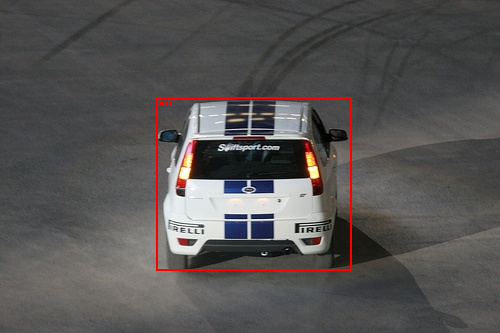

In [20]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    objects = []
    for obj in root.findall("object"):
        name = obj.find("name").text
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        # Convert bounding box coordinates to YOLO format
        width = xmax - xmin
        height = ymax - ymin
        x_center = xmin + (width / 2)
        y_center = ymin + (height / 2)

        # Normalize the coordinates
        image_width = root.find("size/width").text
        image_height = root.find("size/height").text
        x_center /= int(image_width)
        y_center /= int(image_height)
        width /= int(image_width)
        height /= int(image_height)

        # Append object details to the list
        name = class_dict[name]
        objects.append([name, x_center, y_center, width, height])

    return objects


def draw_image(img_path, bboxes):
    img = Image.open(img_path)

    draw = ImageDraw.Draw(img)
    for bbox in bboxes:
        x_center, y_center, width, height = bbox[1], bbox[2], bbox[3], bbox[4]

        x0 = int((x_center - width / 2) * img.width)
        y0 = int((y_center - height / 2) * img.height)
        x1 = int((x_center + width / 2) * img.width)
        y1 = int((y_center + height / 2) * img.height)

        bbox_coords = (x0, y0, x1, y1)
        draw.rectangle(bbox_coords, outline="red", width=2)
        draw.text((x0, y0), classes[bbox[0]], fill="red")
    # Return the modified image
    return img


draw_image(voctrain_ds.images[0], parse_xml(voctrain_ds.annotations[0]))

In [21]:
modified_annotations_train = [parse_xml(i) for i in voctrain_ds.annotations]
modified_annotations_test = [parse_xml(i) for i in vocval_ds.annotations]
train_images = voctrain_ds.images
test_images = vocval_ds.images

[[0, 0.479, 0.46441281138790036, 0.542, 0.3736654804270463], [0, 0.33, 0.37544483985765126, 0.128, 0.12455516014234876], [14, 0.408, 0.7277580071174378, 0.036, 0.17437722419928825], [14, 0.07, 0.7597864768683275, 0.036, 0.17437722419928825]]


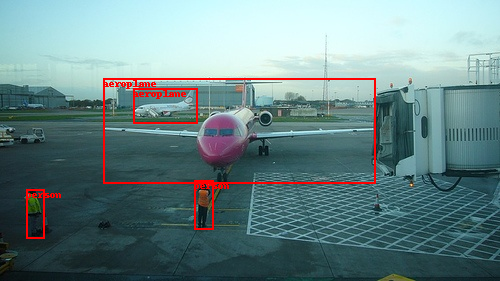

In [22]:
index = 4
print(modified_annotations_train[index])
draw_image(train_images[index], modified_annotations_train[index])

In [23]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        images,
        labels,
        S=7,
        B=2,
        C=20,
        transform=None,
    ):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = self.images[index]
        boxes = self.labels[index]

        image = Image.open(img_path)
        # image = np.array(image)
        boxes = torch.tensor(boxes)

        if self.transform:
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))

        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:
            
            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)
            
            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            if label_matrix[i, j, 20] == 0:
                # Set that there exists an object
                label_matrix[i, j, 20] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 21:25] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [24]:
transform = Compose(
    [
        transforms.Resize((448, 448)),
        transforms.ToTensor(),
    ]
)
train_dataset = VOCDataset(
    train_images, modified_annotations_train, transform=transform
)
test_dataset = VOCDataset(test_images, modified_annotations_test, transform=transform)

In [25]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [26]:
data_iter = iter(train_loader)
first_batch = next(data_iter)

print(
    "Training Batch Size = ",
    first_batch[0].shape,
    "| Output Size",
    first_batch[1].shape,
)

Training Batch Size =  torch.Size([32, 3, 448, 448]) | Output Size torch.Size([32, 7, 7, 30])


Обучение модели

In [27]:
if(torch.cuda.is_available()):
    device = torch.device('cuda')
elif(torch.backends.mps.is_available()):
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [28]:
model = Yolo_v1(split_size=7, num_boxes=2, num_classes=20)
model.to(device)
criterion = YoloLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [29]:
num_epochs = 5
train_acc = []
train_loss = []
val_acc = []
val_loss = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    model.train()  # Set the model to training mode

    for images, labels in train_loader:
        images = images.to(device)  # Move the input tensor to the GPU
        labels = labels.to(device)  # Move the labels tensor to the GPU

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        labels = labels.to(torch.float32)

        loss = criterion(outputs, labels)
        l1 = loss
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    training_loss = running_loss / len(train_loader)

    # Evaluation on test set
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)  # Move the input tensor to the GPU
            labels = labels.to(device)  # Move the labels tensor to the GPU

            outputs = model(images)
            labels = labels.to(torch.float32)

            # Adjust the shape of labels to match the output shape
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            l2 = loss


    test_loss /= len(val_loader)

    train_loss.append(training_loss)
    val_loss.append(test_loss)

    # Print the average loss and accuracy for this epoch
    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: {training_loss:.4f} |   Test Loss: {test_loss:.4f}")

    print(f"  Train Loss: {l1:.4f} |   Test Loss: {l2:.4f}")
    print("*************************")

Epoch 1:
  Train Loss: 2924073.5050 |   Test Loss: 3833974.8105
  Train Loss: 82425.0859 |   Test Loss: 396947.8750
*************************
Epoch 2:
  Train Loss: 714005.3574 |   Test Loss: 595114.4469
  Train Loss: 35759.5547 |   Test Loss: 211235.9375
*************************
Epoch 3:
  Train Loss: 163045.0887 |   Test Loss: 106166.4548
  Train Loss: 2823.8540 |   Test Loss: 530909.1250
*************************
Epoch 4:
  Train Loss: 27763.2938 |   Test Loss: 89937.1017
  Train Loss: 6481.6465 |   Test Loss: 5408.0938
*************************
Epoch 5:
  Train Loss: 19364.2639 |   Test Loss: 26781.7944
  Train Loss: 1655.1797 |   Test Loss: 5598.9985
*************************


In [30]:
final_state = model.state_dict()
torch.save(final_state, 'model_state.pth')

### Оценка модели

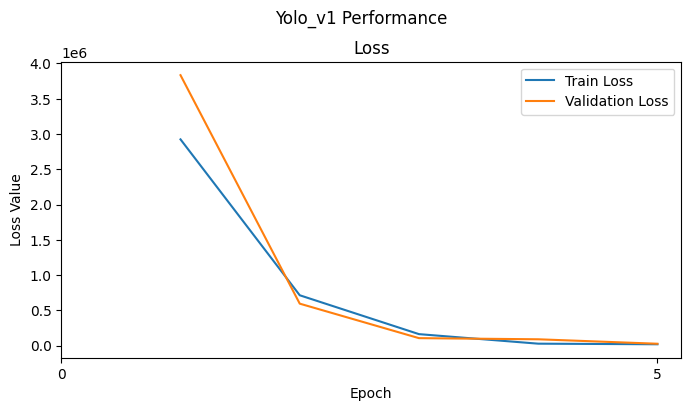

In [31]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.suptitle('Yolo_v1 Performance', fontsize=12)
plt.subplots_adjust(top=0.85)

epoch_list = list(range(1, num_epochs + 1))
ax.plot(epoch_list, train_loss, label='Train Loss')
ax.plot(epoch_list, val_loss, label='Validation Loss')
ax.set_xticks(np.arange(0, num_epochs + 1, 5))
ax.set_ylabel('Loss Value')
ax.set_xlabel('Epoch')
ax.set_title('Loss')
ax.legend(loc="best")

plt.show()

In [35]:
pred_boxes, target_boxes = get_bboxes(
    val_loader, model, iou_threshold=0.5, threshold=0.4
)

mean_avg_prec = mean_average_precision(
    pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
)

print(f"mAP: {mean_avg_prec}")

mAP: 0.00019887990492861718


### Сравнение результатов с базовой моделью

|              | YOLO (base)  | YOLO (v1) |
|--------------|:------------:|:---------:|
| mAP          | 0.2251       | 0.0001    |

### Выводы

Качество имплементированной модели оказалось гораздо хуже готовой модели. Возможно, из-за неверной настройки имплементированной модели.

### Добавление техник из улучшенного бейзлайна

In [29]:
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0
EPOCHS = 25


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

In [30]:
transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


def train_fn(train_loader, model, optimizer, loss_fn, device):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

In [31]:
model = Yolo_v1(split_size=7, num_boxes=2, num_classes=20).to(device)
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss()

### Обучение модели

In [33]:
for epoch in range(EPOCHS):

    pred_boxes, target_boxes = get_bboxes(
        train_loader, model, iou_threshold=0.5, threshold=0.4
    )

    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
    )
    print(f"Epoch {epoch+1}")
    print(f"Train mAP: {mean_avg_prec}")

    train_fn(train_loader, model, optimizer, loss_fn, device)

Epoch 1
Train mAP: 1.1537058526300825e-06


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 668.2961199796653
Epoch 2
Train mAP: 0.000559501932002604


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 468.31290484078323
Epoch 3
Train mAP: 0.0019479425391182303


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 410.23181446896325
Epoch 4
Train mAP: 0.006626496557146311


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 376.9362478135507
Epoch 5
Train mAP: 0.014196964912116528


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 351.32037551493585
Epoch 6
Train mAP: 0.013663718476891518


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 330.367431640625
Epoch 7
Train mAP: 0.019488928839564323


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 306.9873071501527
Epoch 8
Train mAP: 0.04948122426867485


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 287.8806545885303
Epoch 9
Train mAP: 0.08868616819381714


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 265.4260168437716
Epoch 10
Train mAP: 0.14565813541412354


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 248.88930914673625
Epoch 11
Train mAP: 0.2098572552204132


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 236.04345915589153
Epoch 12
Train mAP: 0.2700616121292114


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 221.85697787321067
Epoch 13
Train mAP: 0.3147812485694885


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 210.09602539448798
Epoch 14
Train mAP: 0.35855957865715027


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 199.03182090083254
Epoch 15
Train mAP: 0.40509232878685


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 186.7277191741557
Epoch 16
Train mAP: 0.4368359446525574


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 181.5062362574324
Epoch 17
Train mAP: 0.44743865728378296


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 177.72864131686055
Epoch 18
Train mAP: 0.5194763541221619


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 166.00822627393507
Epoch 19
Train mAP: 0.5583792924880981


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 166.2346176920058
Epoch 20
Train mAP: 0.4472922384738922


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 163.00139840041535
Epoch 21
Train mAP: 0.5609853863716125


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 154.24060633212704
Epoch 22
Train mAP: 0.6235648989677429


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 146.61078240599812
Epoch 23
Train mAP: 0.6330730319023132


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 147.33995732174645
Epoch 24
Train mAP: 0.31854575872421265


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 172.61142373386818
Epoch 25
Train mAP: 0.5941150784492493


  0%|          | 0/79 [00:00<?, ?it/s]

Mean loss was 142.0512666822989


In [34]:
final_state = model.state_dict()
torch.save(final_state, 'model_state.pth')

### Оценка модели

In [35]:
def get_bboxes_with_show(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            if batch_idx == 0 and idx == 0:
               plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
               print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

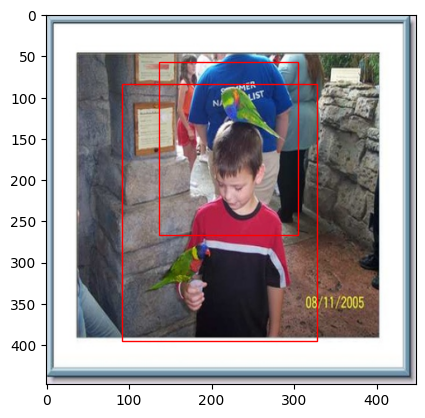

[[2.0, 0.6696977019309998, 0.468900591135025, 0.5349729061126709, 0.5267844200134277, 0.6950916647911072], [14.0, 0.44288772344589233, 0.4921439290046692, 0.3607593774795532, 0.37819167971611023, 0.46900248527526855]]
mAP: 0.0045369332656264305


In [36]:
pred_boxes, target_boxes = get_bboxes_with_show(
    val_loader, model, iou_threshold=0.5, threshold=0.4
)

mean_avg_prec = mean_average_precision(
    pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
)

print(f"mAP: {mean_avg_prec}")

### Сравнение результатов с улучшенным бейзайном

|              | YOLO (upgrade)  | YOLO (v1 + upgrade) |
|--------------|:---------------:|:-------------------:|
| mAP          | 0.5292          | 0.0045              |

### Выводы 

Судя во всему, модель переобучилась, поэтому метрики остались плохими. Для борьбы с переобучением можно применить несколько методов: например, увеличить объем данных, настроить кросс-валидацию или остановить обучение на оптимальной точке.